# Validation - AIS response of models

This notebook evaluates qualitatively the capability of fitted models to reproduce BAC behavior.

In [1]:
import json
import sys
import os
import time
import neuron
from pathlib import Path
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import neuroplotlib as nplt

import bluepyopt as bpopt
import bluepyopt.ephys as ephys
import efel

import LFPy
import neuron
import numpy as np

import shutil

import multimodalfitting as mf

# %matplotlib notebook
# %matplotlib widget
%matplotlib inline

--No graphics will be displayed.


In [2]:
probe_type = "planar"
model_name = "hay_ais" # "hay", "hay_ais", "hay_ais_hillock"
cell_models_folder = Path("../..") / "cell_models"

model_folder = cell_models_folder / f"{model_name}"

In [3]:
result_folder = Path("../..") / "results" / '211124' 
pkl_file_name = "runs.pkl"

data = pickle.load(open(result_folder / pkl_file_name, 'rb'))
df_optimization = pd.DataFrame(data)
df_model = df_optimization.query(f"model == '{model_name}'")

In [4]:
opt_soma = df_model.query("feature_set == 'soma'")
opt_extra = df_model.query("feature_set == 'extra'")
print(f"Somatic optimizations: {len(opt_soma)}")
print(f"Extra optimizations: {len(opt_extra)}")

Somatic optimizations: 10
Extra optimizations: 30


In [5]:
protocols_file = model_folder / "fitting" / "efeatures" / "protocols_BPO_all.json"
features_file = model_folder / "fitting" / "efeatures" / "features_BPO_all.json"

In [6]:
ais_recordings = mf.utils.get_ais_extra_recordings()
protocol_for_eap = "IDrest_300"

In [7]:
extra_kwargs = dict(fs=20,
                    fcut=[300, 6000],
                    filt_type="filtfilt",
                    ms_cut=[3, 5])

In [8]:
cell = mf.create_ground_truth_model(model_name=model_name, release=False)
cell_release = mf.create_ground_truth_model(model_name=model_name, release=True)

probe = mf.define_electrode(probe_type=probe_type)
# probe=None

param_names = [param.name for param in cell.params.values() if not param.frozen]
sim = ephys.simulators.LFPySimulator(cell, cvode_active=True, electrode=probe, mechs_folders=model_folder)

fitness_protocols = mf.define_protocols(
    model_name,
    feature_set="soma",
    protocols_file=protocols_file,
    feature_file=features_file,
    electrode=probe,
    protocols_with_lfp=[protocol_for_eap],
    extra_recordings={protocol_for_eap: ais_recordings}
)

params_release = {}
for param in cell_release.params_by_names(param_names):
    params_release[param.name] = param.value

# Test AIS dynamics

In [9]:
def simulate_responses(cell, params, sim, protocols, protocol_name="IDrest_300", **extra_kwargs):
    response = protocols[protocol_name].run(cell, params, sim)
    eap = mf.calculate_eap(responses=response, protocols=protocols, 
                           protocol_name=protocol_name, **extra_kwargs)
    return response, eap

In [10]:
best_soma = np.argmin(opt_soma.best_fitness)
best_sample_soma = opt_soma.iloc[best_soma]
best_params_soma_dict = {k: v for k, v in zip(param_names, best_sample_soma.best_params)}
display(best_sample_soma.best_fitness)

opt_all = opt_extra.query("extra_strategy == 'all'")
opt_sections = opt_extra.query("extra_strategy == 'sections'")
opt_single = opt_extra.query("extra_strategy == 'single'")

best_all = np.argmin(opt_all.best_fitness)
best_sections = np.argmin(opt_sections.best_fitness)
best_single = np.argmin(opt_single.best_fitness)

best_sample_all = opt_all.iloc[best_all]
best_params_all_dict = {k: v for k, v in zip(param_names, best_sample_all.best_params)}
display("ALL", best_sample_all.best_fitness)

best_sample_sections = opt_sections.iloc[best_sections]
best_params_sections_dict = {k: v for k, v in zip(param_names, best_sample_sections.best_params)}
display("SECTIONS", best_sample_sections.best_fitness)

best_sample_single = opt_single.iloc[best_single]
best_params_single_dict = {k: v for k, v in zip(param_names, best_sample_single.best_params)}
display("SINGLE", best_sample_single.best_fitness)

77.38338284071976

'ALL'

102.07351374274587

'SECTIONS'

109.97120813259048

'SINGLE'

4169.315873316626

In [11]:
print("Computing RELEASE")
response_release, eap_release = simulate_responses(cell, params_release, sim, fitness_protocols, 
                                                   protocol_name=protocol_for_eap, **extra_kwargs)
print("Computing SOMA")
response_soma, eap_soma = simulate_responses(cell, best_params_soma_dict, sim, fitness_protocols, 
                                             protocol_name=protocol_for_eap, **extra_kwargs)
print("Computing ALL")
response_all, eap_all = simulate_responses(cell, best_params_all_dict, sim, fitness_protocols, 
                                           protocol_name=protocol_for_eap, **extra_kwargs)
print("Computing SECTIONS")
response_sections, eap_sections = simulate_responses(cell, best_params_sections_dict, sim, fitness_protocols, 
                                                     protocol_name=protocol_for_eap, **extra_kwargs)
print("Computing SINGLE")
response_single, eap_single = simulate_responses(cell, best_params_single_dict, sim, fitness_protocols, 
                                                 protocol_name=protocol_for_eap, **extra_kwargs)

Computing RELEASE
Computing SOMA
Computing ALL
Computing SECTIONS
Computing SINGLE


In [12]:
# helper functions to cutout one spike

In [13]:
resp_cut_release = mf.utils.get_peak_cutout(response_release)
resp_cut_soma = mf.utils.get_peak_cutout(response_soma)
resp_cut_all = mf.utils.get_peak_cutout(response_all)
resp_cut_sections = mf.utils.get_peak_cutout(response_sections)
resp_cut_single = mf.utils.get_peak_cutout(response_single)

In [14]:
responses_to_plot = ['IDrest_300.soma.v', 
                     'IDrest_300.ais_mid_v.v', 
                     'IDrest_300.ais_end_v.v']

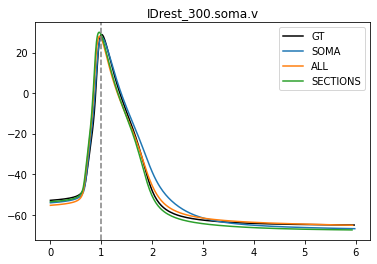

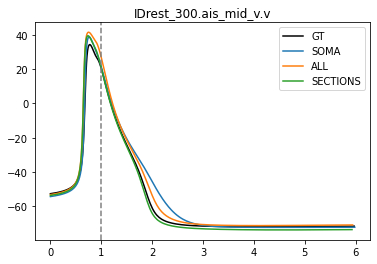

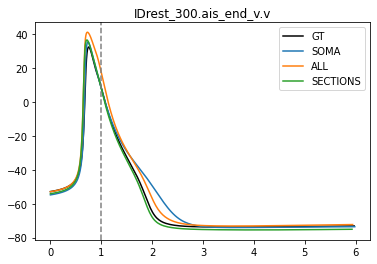

In [15]:
for resp_name in responses_to_plot:
    fig, ax = plt.subplots()
    ax.plot(resp_cut_release[resp_name]["time"], resp_cut_release[resp_name]["voltage"], color="k", label="GT")
    ax.plot(resp_cut_soma[resp_name]["time"], resp_cut_soma[resp_name]["voltage"], color="C0", label="SOMA")
    ax.plot(resp_cut_all[resp_name]["time"], resp_cut_all[resp_name]["voltage"], color="C1", label="ALL")
    ax.plot(resp_cut_sections[resp_name]["time"], resp_cut_sections[resp_name]["voltage"], color="C2", 
            label="SECTIONS")
    ax.axvline(1., color="gray", ls="--")
#     ax.plot(resp_cut_single[resp_name]["time"], resp_cut_single[resp_name]["voltage"], color="C3", label="SINGLE")
    ax.legend()
    ax.set_title(resp_name)

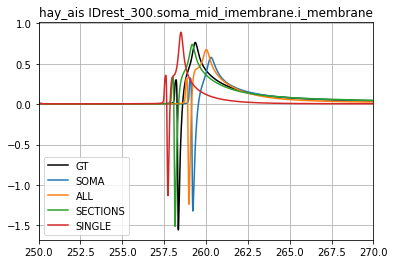

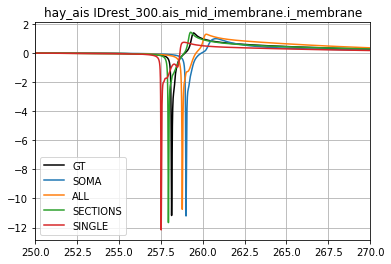

In [20]:
protname_soma='IDrest_300.soma_mid_imembrane.i_membrane'
protname_ais ='IDrest_300.ais_mid_imembrane.i_membrane'

for resp_name in [protname_soma,protname_ais]:
    fig, ax = plt.subplots()
    ax.plot(response_release[resp_name]["time"], response_release[resp_name]["voltage"], color="k", label="GT")
    ax.plot(response_soma[resp_name]["time"], response_soma[resp_name]["voltage"], color="C0", label="SOMA")
    ax.plot(response_all[resp_name]["time"], response_all[resp_name]["voltage"], color="C1", label="ALL")
    ax.plot(response_sections[resp_name]["time"], response_sections[resp_name]["voltage"], color="C2", label="SECTIONS")
    ax.plot(response_single[resp_name]["time"], response_single[resp_name]["voltage"], color="C3", label="SINGLE")
    ax.set_xlim([250,270])
    ax.grid()
    ax.legend()
    ax.set_title("hay_ais " + resp_name)